### Linear Model
Use the 37GHz V-pol band to predict ERA5 skin temperature (Both for Ascending and Descending passes)

In [1]:
from sklearn.linear_model import LinearRegression, HuberRegressor

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors

import xarray as xr
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '../..')))

from src.processing import windsat_datacube, create_landmask

In [2]:
# Load
ws_path = "../../data/raw/daily_Windsat/"
wsds = windsat_datacube(ws_path)

igbp_path = "../../data/processed/IGBP_WindsatGrid.h5"
igbp_ds = xr.open_dataset(igbp_path)

# # Mask out the ocean
# landmask = create_landmask(lon=wsds.lon.values, lat = wsds.lat.values)
# wsds["landmask"] = (("latitude_grid","longitude_grid"),landmask.values)
# wsds = wsds.where(wsds.landmask == 0)

# Use the IGBP classification and select all classes by 0 "water". It also removes big lakes.
wsds["IGBP"] = (("latitude_grid","longitude_grid"),igbp_ds.IGBP.values)
wsds = wsds.where(wsds.IGBP != 0)

# Map grid to lat-lon for plotting
wsds = wsds.swap_dims(
    {
        "latitude_grid": "lat",
        "longitude_grid": "lon",
    }
)
wsds = wsds.sortby(['lat', 'lon'])



# Select TbToA for  Ka V pol band, alongise the objective temperature
selection ={
    "polarization": 1, # 1 - Vertical
    "frequency_band": 1 # 1 - 37GHz
}
dvar_selection = ["tbtoa","surtep_ERA5"]
tbs = wsds.sel(**selection).reset_coords()[dvar_selection]

#Ascending vs descendig model
asc_tbs = tbs.sel(swath_sector = 0)
des_tbs = tbs.sel(swath_sector = 1)

datasets = [asc_tbs, des_tbs]


In [10]:
# All data plots:

fig, axs = plt.subplots(1,2, figsize = (14,10))

hexbinnorm = LogNorm(vmin= 1)
hexbin_kw = {
    "gridsize" : 80,
    "alpha" : 1,
    "edgecolors": "White",
    "norm" : hexbinnorm

}
regression_kw = {
    "color" : "Red",
    "alpha" : 0.7,
    "linestyle" : "--"
}
index2pass = {
    0 : "Ascending",
    1 : "Descending",
}

for i, ds in enumerate(datasets):
    ax = axs[i]
    df = ds.to_dataframe().reset_index(drop=True).dropna()
    
    ax.hexbin(x = df["tbtoa"], y = df["surtep_ERA5"], **hexbin_kw)

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    ax.axline((0,273.15), slope= 0, color = "Black", alpha = 0.5)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.set_xlabel("Tbtoa [K]")
    ax.set_ylabel("ERA5 Skin Temperature [K]")
    ax.set_title(f"{index2pass[i]} pass")

cbar = plt.colorbar(ScalarMappable(norm=hexbinnorm, cmap="viridis"), ax=ax, orientation='vertical', pad=0.05, label = "Count (Log)")




In [7]:

# Linear regression with each swath sector:
regs = []
dataframes = [ds.to_dataframe().reset_index(drop=True).dropna() for ds in datasets]

# Select temperatures avobe 2ºC
corrected_datasets = [ds.where(tbs.surtep_ERA5 > (273.15 + 2)) for ds in datasets]

dataframes = [ds.to_dataframe().reset_index(drop=True).dropna() for ds in corrected_datasets]
for df in dataframes:

    X=df["tbtoa"].values.reshape(-1, 1)
    y=df["surtep_ERA5"].values
    
    reg = LinearRegression()
    reg.fit(X, y)
    regs.append(reg)

    # Evaluate the model
    linear_score = reg.score(X, y)
    print("Model score:", linear_score)
    print(reg.intercept_, reg.coef_)


Model score: 0.2502088061813674
211.06699 [0.30505085]
Model score: 0.2586995925226335
222.06958 [0.25033346]


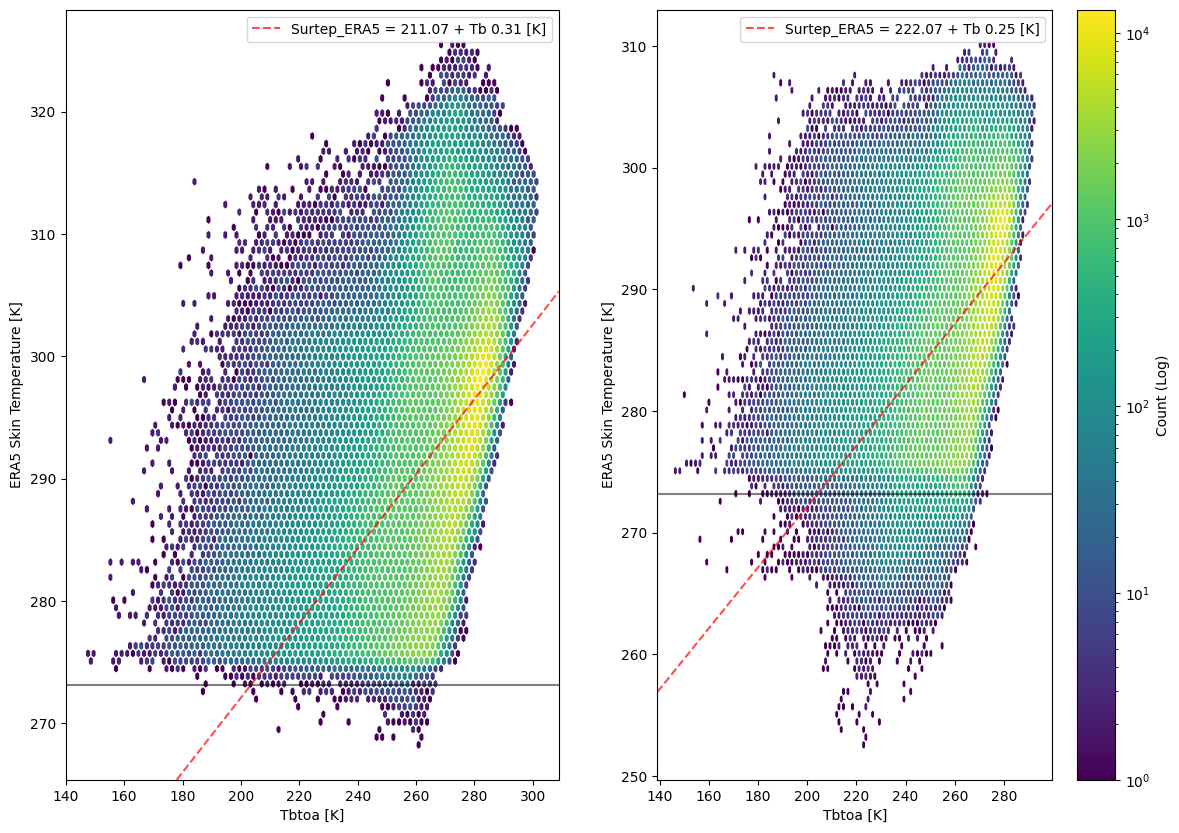

In [8]:
# Plots of corrected data:
fig, axs = plt.subplots(1,2, figsize = (14,10))

hexbinnorm = LogNorm(vmin= 1)
hexbin_kw = {
    "gridsize" : 80,
    "alpha" : 1,
    "edgecolors": "White",
    "norm" : hexbinnorm

}
regression_kw = {
    "color" : "Red",
    "alpha" : 0.7,
    "linestyle" : "--"
}

for i, df in enumerate(dataframes):
    reg = regs[i]
    ax = axs[i]
    
    ax.hexbin(x = df["tbtoa"], y = df["surtep_ERA5"], **hexbin_kw)

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    ax.axline((0,273.15), slope= 0, color = "Black", alpha = 0.5)
    reg_label = f"Surtep_ERA5 = {reg.intercept_:.2f} + Tb {reg.coef_[0]:.2f} [K]"
    ax.axline((0,reg.intercept_), slope= reg.coef_[0], **regression_kw, label=reg_label)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.set_xlabel("Tbtoa [K]")
    ax.set_ylabel("ERA5 Skin Temperature [K]")

    ax.legend()


cbar = plt.colorbar(ScalarMappable(norm=hexbinnorm, cmap="viridis"), ax=ax, orientation='vertical', pad=0.05, label = "Count (Log)")




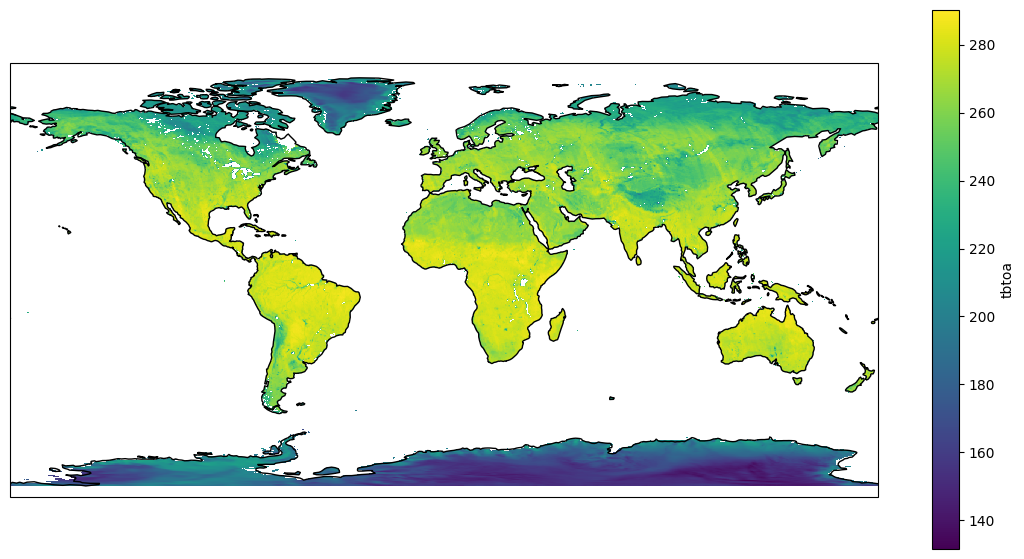

In [9]:
import cartopy.crs as ccrs
fig, ax = plt.subplots(1,1,figsize = (14,7), subplot_kw={"projection": ccrs.PlateCarree()})

asc_tbs.tbtoa.mean(dim="day_number").plot()
ax.coastlines()

In [ ]:
# TODO: add a map of the errrors to see what is happening